<a href="https://colab.research.google.com/github/anupmerkap87/Diagnosing-depression-using-EEG/blob/main/Code/Feature_Extraction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

***
<b>Background</b>
***

Mental disorder incidence is increasing rapidly over the past 2 decades[1] with global depression diagnosed patients reaching 322M as of 2015. Major Depressive Disorder (MDD) has become a leading contributor to the global burden of disease. However, it is diagnosed through a series of interviews carried out by Psychiatrists and Psychologists. The process is not only labor-consuming but also time-consuming. The result of depression diagnosis is also not as convincing as some other illness, such as hypertension and heart disease, due to its lack of physiological indicators. Not to mention, most countries are suffering from a lack of psychiatrically and physiological doctors, especially the less developed countries. All these reasons are causing the global population to still widely undiagnosed and untreated for
their mental health disorders. 

With the rising of tools such as data mining and artificial intelligence, using
physiological data to explore new possible physiological indicators of mental disorder and creating new applications for mental disorder diagnosis has become a new research hot topic. Electroencephalography (EEG), as a non-invasive physiological data, provides a direct measure of postsynaptic potentials with millisecond temporal resolution. Since mental disorders, such as depression, are complex brain cognitive disfunction, EEG is naturally the common data that are favored by the researchers. 

While our blog post details prior analysis in this area, our capstone project presents a multi-modal open dataset for mental-disorder analysis. The dataset includes data mainly from clinically depressed patients and matching normal controls. All patients were carefully diagnosed and selected by professional psychiatrists in hospitals. For more details, please refer to our blog post. The EEG dataset includes data collected using traditional 128-electrodes mounted elastic cap. The 128-electrodes EEG signals of 53 subjects were recorded as both in resting state and under stimulation. Detail descriptions of each sub-dataset are listed accordingly in the following section

The main objective for this Capstone project are -

1. Traditional research on the EEG waveforms were done through MATLAB. We will first have to implement all the functions of MATLAB through native Python librarires like <b>MNE, SCIPY, STATSMODEL</b>
2. Build detailed <b>feature engineering</b> for Resting and simulated information (we refer to this as ERP). Here we will try extracting Linear Features (directly extracted from the waveform with minimal manipulation), Non-Linear Features (entropy / energy related variables)
3. Building Classification model that can further differentiate between patients and normal population

It is worth noting that the data that we procured is 58 sets of Patient level data for both Resting and ERP. This means, we will have to hand pick each EEG dataset for Resting and ERP followed by processing them for feature extraction

***
About the Notebook
***

We will rely on the research that is already available in this field (refer blog post for more details) on some of the choices that we make over the process

Flow of this notebook -
1. <b>Pre-requisites:</b> Install all the requirements and import libraries needed
2. <b>Utility functions</b>: This section explains the EEG signal extraction - Some perspectives on how we are creating linear and non-linear features
3. <b>Data Cleansing</b>: Creating a unified dataframe for all the patients in one place
4. <b>Data Manipulation</b>: Few univariate and bivariate summaries to help us in feature reduction
5. <b>Model development</b>: Develop model at various decision points
6. <b>Explainability</b>: Results and how the model performs for demographic population

#1. Pre Requisites

As described in the introduction dataset, we will need to translate the algorithms/ feature extraction steps implemented in MATLAB to Python. Fortunately, [MNE Library](https://mne.tools/stable/index.html) implements most of the common feature engineering steps. Along with MNE, we utilized packages in Statsmodel.

Few details on MNE: MNE is considered to Pandas for health care / wearables data. It has interesting functions to extract multi modal features - We invested 2 weeks of our Capstone time on the MNE Tutorials to learn various ways of handling the EEG waveform. While the notebook skims through the best structure of the code that we can bring here, there are series of experimentations that went in the background to attain state that we are in right now

In [ ]:
!pip install mne

In [ ]:
!pip install antropy

In [ ]:
pip install matplotlib

In [ ]:
pip install watermark

In [ ]:
#Libraries helping with file retrival
import os
from os import listdir
from os.path import isfile, join

#Visualization and data manipulation libraries
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import butter, lfilter
import mne
import pandas as pd
import numpy as np
import antropy as ant
import seaborn as sns
sns.set(font_scale=1.2)

#Model development and understanding
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score

In [ ]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [ ]:
%watermark --iversions

pandas    : 1.1.5
matplotlib: 3.2.2
IPython   : 5.5.0
mne       : 0.24.1
scipy     : 1.4.1
antropy   : 0.1.4
seaborn   : 0.11.2
google    : 2.0.3
numpy     : 1.19.5



In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Utility Function

Across this section, we first walk you through the various utility functions. To help understanding these utility functions, we will take one patient's EEG waveform and explain through the process

## Background

A typical EEG device has a series of electrodes. The electrodes are placed on the scalp of the patient - These electrodes then extract voltage - Which are then encoded as signal data. for example, if there are n electrodes, each electrode will generate a time series of voltage values. The voltage values from one position to other position in the brain varies. The aim of our capstone exercise is to find those distingushing features and build a classification model

We now understand the electrodes. Now these electrodes have to work under some sampling frequency. To keep it simple, the number of datapoints that we gather per second. Hence for n electrode if the sampling freqency is s, we will get n*s data points per second

The experiment set-up that we have is done in two forms -
1. Resting - The files are present in .mat format
2. Simulated activity - The files are present in .raw format

The system that was used to generate these signal is 128 Channel HydroCelGSN. An electrode location file was shared by the research team - However, we found it easy to use MNE's in built packages to process the files. 

### Reading .raw file

Steps Involved:

1. First set the *montage* for the EEG waveform. The montage that we used is 'GSN-HydroCel-128'. More montages can be found in this [location](https://mne.tools/stable/generated/mne.channels.make_standard_montage.html#mne.channels.make_standard_montage)
2. Read the EEG signal for a single patient through read_raw_egi function. We used this function because the signal is extracted from EGI based system
3. We are going to delete reference electrode 'E129' as it doesn't have any significance

Creating RawArray with float64 data, n_channels=128, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


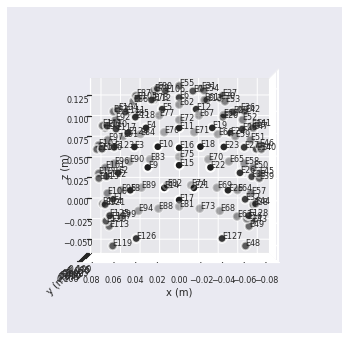

In [ ]:
#Function to import the dataset, make some cleanups and return the data
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')

#Visualize the Montage positions
fig = montage.plot(kind='3d',scale_factor = 10)

In [ ]:
#Function to import the dataset, make some cleanups and return the data
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')

def file_importer(path='/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015/02010002erp 20150416 1131.raw',type =1):
  """
  Inputs:
  path = Location of the raw file
  type = 1 / 0 indicating raw or mat format
  Outputs:
  Returns the .raw object for EEG
  """
  if type == 1:
    df = mne.io.read_raw_egi(path,verbose=True)
    #Delete the bad signal that we identified
    df.drop_channels('E129')
    #Just set the montage - Though the research institution provided us the montage file, 
    #there are numerous challenges importing the file as the matlab native format is not set in the 
    #mne package. As a result, we will be utilizing make_standard_montage file present in the mne library -- 
    #As the machine that was used is related to 'GSN_HydroCel-129'. However, kindly ensure that we are 
    #deleting the dead signal E129
  else:
    ch_names = ['E'+str(i+1) for i in range(128)]
    sampling_freq = 250
    mat = scipy.io.loadmat(path)
    key = list(mat.keys())
    data = key[3]
    a_mat = mat[data]
    info = mne.create_info(ch_names= ch_names,
                       ch_types='eeg', verbose=None,
                       sfreq=sampling_freq)
    df = mne.io.RawArray(a_mat[:-1,:], info)

  df.set_montage(montage)
  #df = df.pick_channels(ch_names = list(Electrode_map.values()))
  df.plot_psd()
  return df    

Reading EGI header from /content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015/02010002erp 20150416 1131.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {SESS} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
Effective window size : 8.192 (s)


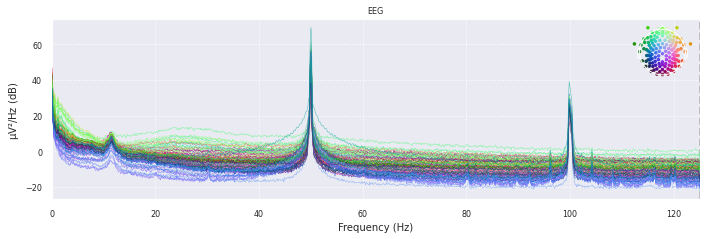

In [ ]:
raw_erp = file_importer()

Creating RawArray with float64 data, n_channels=128, n_times=78639
    Range : 0 ... 78638 =      0.000 ...   314.552 secs
Ready.
Effective window size : 8.192 (s)


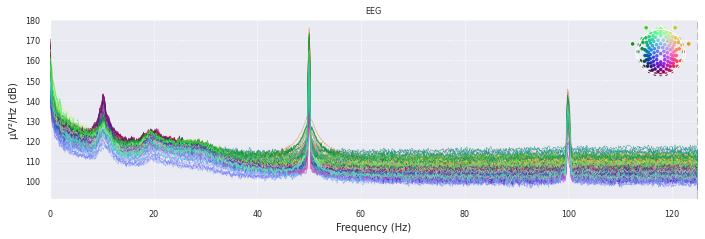

In [ ]:
#Sample Output
raw_rest = file_importer('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015/02010006rest 20150528 0928..mat',type = 0)

In [ ]:
#Electrodes to be considered -
#Source - https://www.egi.com/images/HydroCelGSN_10-10.pdf

Electrode_map = {'C3':'E36','C4':'E104','F3':'E24','F4':'E124','F7':'E33','F8':'E122',
                 'FP1':'E22','FP2':'E9','O1':'E70','O2':'E83','P3':'E52','P4':'E92',
                 'T3-T7':'E45','T4-T8':'E108','T5-P7':'E58','T6-P8':'E96'}
Electrode_understanding = {'Left-Central':'E36','Right-Central':'E104','Front-Left':'E24','Front-Right':'E124',
                           'Front-Far left':'E33','Front-Far Right':'E122',
                           'Forehead (above left eye)':'E22','Forehead (above Right eye)':'E9',
                           'Back-left to Center':'E70','Back-Right to Center':'E83','Back-Above E70':'E52',
                           'Back-Above E83':'E92','Side Left':'E45','Side Right':'E108','Left':'E58','Right':'E96'}

#Electrodes to pick
list(Electrode_map.values())

['E36',
 'E104',
 'E24',
 'E124',
 'E33',
 'E122',
 'E22',
 'E9',
 'E70',
 'E83',
 'E52',
 'E92',
 'E45',
 'E108',
 'E58',
 'E96']

Effective window size : 8.192 (s)


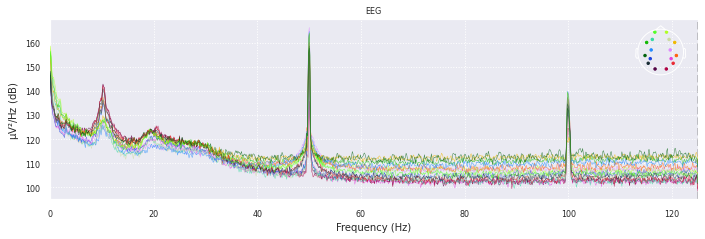

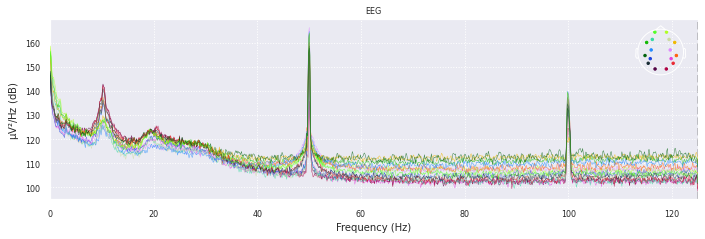

In [ ]:
#Checking out if we filter for 16 electrodes

raw_rest.pick_channels(list(Electrode_map.values())).plot_psd()

<b>Understanding output -</b>

The file importer reads one file. The montage is set as we discussed in earlier sections. Post that, we plotted the Power spectral distribution for various signals. The top right side of the chart contains the electrode positions. One interesting thing to note is at 50Hz, 100Hz, 150Hz, there is a spike in Power. This is due to AC current in country where experiment is done - It is called Power Line Noise. There are various ways through which, we can eliminate this noise using Filters. While the various forms of filters are out of the discussion, we utilized a Band pass filter of 1-50Hz. That forms the next function

## Designing Band pass filter

We will be using hamming window filter for the scope of this problem. The description for the filter design and variations can be seen in this [location](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html?highlight=filters)

Initial Power distribution
After filtering - Power distribution
Reading 0 ... 197401  =      0.000 ...   789.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 8.192 (s)


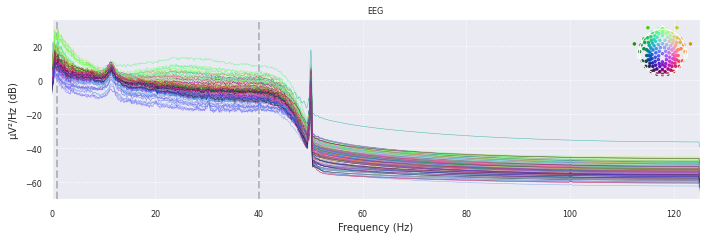

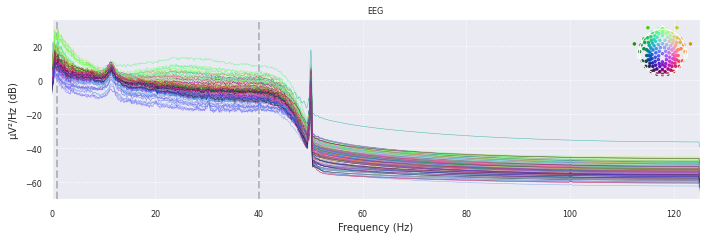

In [ ]:
sampling_freq = 250
# the EEG data were filtered (bandpass = 1–40 Hz) using a Hamming windowed Sinc FIR filter
l_freq = 1
h_freq = 40
# Applying filters
def raw_trunc(simulated_raw):
  simulated_raw =simulated_raw.copy().load_data()
  simulated_raw_truc = simulated_raw.filter(l_freq,h_freq,method = 'fir',fir_window = 'hamming')
  return simulated_raw_truc

print("Initial Power distribution")
#raw = file_importer()
print("After filtering - Power distribution")
raw_trunct = raw_trunc(raw_erp)
raw_trunct.plot_psd()

<b>Understanding ouput</b>: The first chart shows the power distribution for raw waveform. However, the second chart shows the smoothened components with signal tapering off post 50Hz. While we showed the implementation in MNE, we will be implementing the same filter using the statsmodel functionality as we need to convert our EEG waveform to numpy array for feature engineering

In [ ]:
def butter_bandpass_filter(data):
  """
  Inputs :
  data -Raw eeg data
  lowcut-low pass frequency
  highcut-high pass frequency
  fs-sampling frequenct
  Order - Order at which filter needs to be designed
  Outputs:
  y - Filtered signal
  """
  fs = 256                                # Sampling rate (256 Hz)
  eeg_bands = {'delta':(1,4),
               'Theta': (4, 8),
               'Alpha': (8, 12),
               'Beta': (12, 30),
               'Gamma': (30, 45),
               'Normal':(0,40)}
  # Get real amplitudes of FFT (only in postive frequencies)
  fft_vals = np.absolute(np.fft.rfft(data))
  # Get frequencies for amplitudes in Hz
  fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

  # Take the mean of the fft amplitude for each EEG band
  eeg_band_mean = dict()
  eeg_band_median = dict()
  eeg_band_max = dict()
  eeg_band_min = dict()
  eeg_band_fft = dict()
  for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                      (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    eeg_band_median[band] = np.median(fft_vals[freq_ix])
    eeg_band_mean[band] = np.mean(fft_vals[freq_ix])
    eeg_band_max[band] = np.max(fft_vals[freq_ix])
    eeg_band_min[band] = np.min(fft_vals[freq_ix])

  return eeg_band_mean,eeg_band_median,eeg_band_max,eeg_band_min,eeg_band_fft

## Feature Extraction - Linear Features

Over the next module, we will be designing a simple function to extract the linear features of the EEG waveform. While the actual mathematical formulaes will not be comprehended for a data science practitioner, we will try to provide an intution on what these linear features mean

1. Mean amplitude (peak to peak) of the power signal
2. Median amplitude (peak to peak) of the power signal
3. Maximum amplitude (peak to peak) of the power signal
4. Minimum amplitude (peak to peak) of the power signal
5. Power at alpha
6. Power at beta
7. Power at delta
8. Power at theta

While the top 4 features are pretty straight forward, initial research in the area mentioned that alpha, beta, delta, theta frequency power signals are different between the depression patients and others

In [ ]:
def signal_extractor(df,prefix):
  """
  Input:
  df - .raw object : EEG Waveform data
  prefix - It is used to name the columns
  Output:
  returns 'result'. It is a pandas dataframe with dimensions 149*8 (128 electrodes
  +21 event trigger stim channels (More details to follow) each having 8 features)
  """

  d = df.get_data()  
  ch_names = df.ch_names
  val_dict = dict()
  for i in np.arange(d.shape[0]):
      data = d[i,:]
      eeg_band_mean,eeg_band_median,eeg_band_max,eeg_band_min,eeg_band_fft = butter_bandpass_filter(data)
      mean = eeg_band_mean['Normal']
      max = eeg_band_max['Normal']
      min = eeg_band_min['Normal']
      median = eeg_band_median['Normal']
      alpha = eeg_band_fft['Alpha']
      beta = eeg_band_fft['Beta']
      delta = eeg_band_fft['delta']
      theta = eeg_band_fft['Theta']
      objects = [alpha, beta, delta,theta,mean,max,min,median]
      val_dict[ch_names[i]] = objects
  result = pd.DataFrame(val_dict).T
  result.columns = ['lf_alpha_'+prefix,'lf_beta_'+prefix,'lf_delta_'+prefix,'lf_theta_'+prefix,'lf_mean_'+prefix,'lf_max_'+prefix,'lf_min_'+prefix,'lf_median_'+prefix]
  return result

In [ ]:
signal_extractor(raw_erp,'one_pat').head()

,lf_alpha_one_pat,lf_beta_one_pat,lf_delta_one_pat,lf_theta_one_pat,lf_mean_one_pat,lf_max_one_pat,lf_min_one_pat,lf_median_one_pat
E1,0.009197,0.004703,0.029170,0.011922,0.020509,126.454099,0.000036,0.004709
E2,0.008355,0.004442,0.030665,0.010765,0.056791,1315.108658,0.000027,0.004451
E3,0.010076,0.006516,0.041635,0.014003,0.090575,2109.456340,0.000040,0.006722
E4,0.010546,0.005984,0.041639,0.014799,0.040119,526.747381,0.000038,0.006238
E5,0.010841,0.005423,0.044506,0.016488,0.054184,884.714861,0.000066,0.005555


## Feature Extraction - Non Linear Features

The nonlinear features Singular-value deposition entropy
(SVDen) and Spectral entropy. They define the information loss in the given signal. There are various other entropy forms. However, due to limitations with the infrastructure we are going ahead with these two forms of entropy only

In [ ]:
#Non Linear Features
def nli_features(df,prefix):
  """
  Input:
  df - .raw object : EEG Waveform data
  prefix - It is used to name the columns
  Output:
  returns 'result'. It is a pandas dataframe with dimensions 149*2 (128 electrodes
  +21 event trigger stim channels (More details to follow) each having 2 features)
  """
  ch_names = df.ch_names
  val_dict = dict()
  overall = raw_trunc(df.copy())
  d = overall.get_data()  
  # Extract Non Linear features
  for i in range(d.shape[0]):
    signal = d[i,:]
    svd_entropy = ant.svd_entropy(signal, normalize=True)
    spectral_entropy = ant.spectral_entropy(signal, sf=250, method='welch', normalize=True)
    perm_entropy = ant.perm_entropy(d[i,:], normalize=True)
    #app_entropy = ant.app_entropy(d[i,:])
    #sample_entropy = ant.sample_entropy(d[i,:])
    
    #objects = [svd_entropy,spectral_entropy,perm_entropy,app_entropy,sample_entropy]
    objects = [svd_entropy,spectral_entropy,perm_entropy]
    val_dict[ch_names[i]] = objects
  result = pd.DataFrame(val_dict).T
  #result.columns = ['nl_svden_'+prefix,'nl_spec_en'+prefix,'nl_permen'+prefix,'nl_appen'+prefix,'nl_sampen'+prefix]
  result.columns = ['nl_svden_'+prefix,'nl_spec_en'+prefix,'nl_permen'+prefix]
  return result  

In [ ]:
#Sample output
nli_features(raw_erp,'one_pat').head()

Reading 0 ... 197401  =      0.000 ...   789.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



,nl_svden_one_pat,nl_spec_enone_pat,nl_permenone_pat
E1,0.472424,0.490312,0.783087
E2,0.460892,0.467293,0.778375
E3,0.574941,0.546001,0.803617
E4,0.598420,0.585663,0.826692
E5,0.576004,0.600490,0.819386


## Preprocessing filters and checks

1. Earlier researchers in this area picked 16 electrodes each belonging to a different location of the brain and suggest that they are representative of the entire eeg waveform. We will also pick those 16 electrodes. We will use universal 10-10 encoding of the channels to identify the 16 electrodes. This drastically reduces the dimensions from 128 to 16 channels

In [ ]:
#Electrodes to be considered -
#Source - https://www.egi.com/images/HydroCelGSN_10-10.pdf

Electrode_map = {'C3':'E36','C4':'E104','F3':'E24','F4':'E124','F7':'E33','F8':'E122',
                 'FP1':'E22','FP2':'E9','O1':'E70','O2':'E83','P3':'E52','P4':'E92',
                 'T3-T7':'E45','T4-T8':'E108','T5-P7':'E58','T6-P8':'E96'}
Electrode_understanding = {'Left-Central':'E36','Right-Central':'E104','Front-Left':'E24','Front-Right':'E124',
                           'Front-Far left':'E33','Front-Far Right':'E122',
                           'Forehead (above left eye)':'E22','Forehead (above Right eye)':'E9',
                           'Back-left to Center':'E70','Back-Right to Center':'E83','Back-Above E70':'E52',
                           'Back-Above E83':'E92','Side Left':'E45','Side Right':'E108','Left':'E58','Right':'E96'}

#Electrodes to pick
list(Electrode_map.values())

['E36',
 'E104',
 'E24',
 'E124',
 'E33',
 'E122',
 'E22',
 'E9',
 'E70',
 'E83',
 'E52',
 'E92',
 'E45',
 'E108',
 'E58',
 'E96']

2. The Activity data is a simulated experiment. The experiment sequence is as follows - 

The task consisted of three blocks (Fear-Neutral, Sad-Neutral, and Happy-Neutral), and each block had 160 trials. At the beginning of each trial, a fixed white cross appeared on the central screen at 300 ms and lasted for 300 ms from the start. Then, the cross was presented on the screen centrally on the screen throughout the experiment. The emotional-neutral face stimuli pair was presented on the screen as a cue for 500 ms, the pair was arranged in a pseudo-random order. After a short
interval from 100–300 ms, the dot-probe appeared randomly as a target on the left or right position of the fixed cross for 150 ms. Concurrently, the participant was asked to identify the spatial location of the ‘dot’ and to record their response by pressing the button ‘1’ or ‘4’ on the reaction box with their index fingers as quickly as possible. If the dot appeared to the left of the fixation cross, the subject should press ‘1’; if the dot appeared to the right of the fixation cross, the subject should press ‘4’. An automatic interval of 2000 ms was used to receive the response of the participant; otherwise, the participant would be directed into the subsequent trial that was followed by a black screen presented for 600 ms. The procedure continued gradually until a block was completed. Each block was also run in a cycle manner until the entire task was finished. The whole experimental task was completed in about 25 min. The trial sequence of the dot-probe task is illustrated

![Sequences](https://drive.google.com/uc?export=view&id=16EkiyDFXzDSkAIIvoLsExvN93LSKeaKs)

They are stored in series of stim channels -

![Channels](https://drive.google.com/uc?export=view&id=1EmoaTnFDIJz_tf25GPkY_19Hm2DGRH9U)

Using matplotlib as 2D backend.


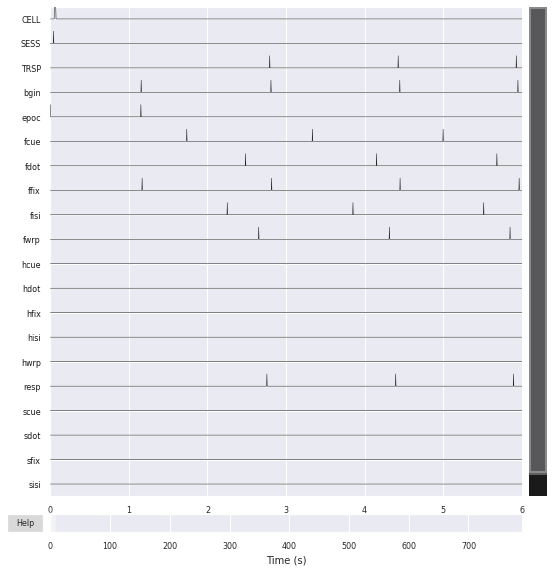

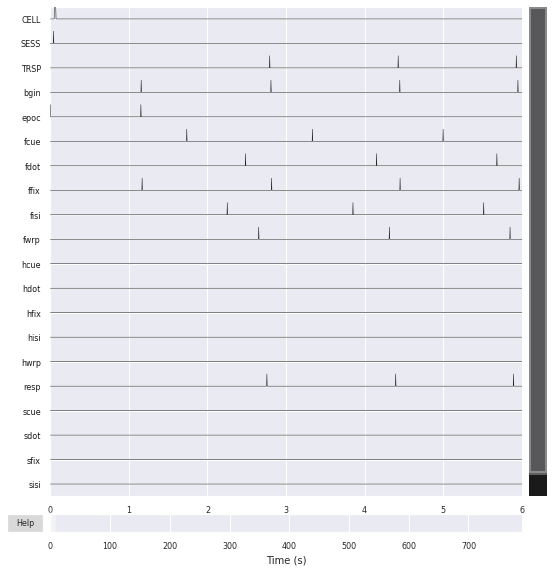

In [ ]:
#We can visualize them here -

raw_erp.copy().pick_types(meg=False, stim=True).plot(start=0, duration=6)

We see that the sequence started with Fear-neutral images. However, we faced one key challenge in processing this information in MNE. MNE is not able to read the events properly as there are overlapping events between various channels. This is resulting in erroneous results

We mitigate this issue by truncating the signal into 'Happy','Sad' and 'Fear' waveforms. It is essentially division of the waveform into 3 different waveforms by looking into the sequence of the events

In [ ]:
def channel_explorer(df):
  """
  Input
  df - EEG Waveform from the simulated experiment
  Output
  returns -
  Happy waveform, Sad waveform, Fear waveform 
  as a tuple
  """
  #Select only the STIM channels (channels that stores impulses)
  list_channels = df.copy().pick_types(meg=False, stim=True).ch_names
  #Get the data in numpy format
  temp = pd.DataFrame(df.copy().pick_types(meg=False, stim=True).get_data().T)
  #Set the column names as per the incoming electrode positions
  temp.columns = list_channels
  temp.reset_index(inplace = True)

  #initialization
  df_happy = pd.DataFrame()
  df_sad = pd.DataFrame()
  df_fear = pd.DataFrame()

  #Loop to go through each emotion and output the values
  for col in temp.columns:
    if col!='index':
      if col in ['fcue', 'fdot','ffix', 'fisi', 'fwrp']:
        te = pd.DataFrame(temp[temp[col]==1].agg({'index':['max','min']}))
        te.columns = [col]
        df_fear = pd.concat([df_fear,te],axis = 1)
      if col in ['hcue', 'hdot', 'hfix', 'hisi', 'hwrp']:
        te = pd.DataFrame(temp[temp[col]==1].agg({'index':['max','min']}))
        te.columns = [col]
        df_happy = pd.concat([df_happy,te],axis = 1)
      if col in ['scue', 'sdot', 'sfix', 'sisi', 'swrp']:
        te = pd.DataFrame(temp[temp[col]==1].agg({'index':['max','min']}))
        te.columns = [col]
        df_sad = pd.concat([df_sad,te],axis = 1)
  event_dict = {'fear':(np.min(df_fear,axis = 1)[1],np.max(df_fear,axis = 1)[0]),
                'sad':(np.min(df_sad,axis = 1)[1],np.max(df_sad,axis = 1)[0]),
                'happy':(np.min(df_happy,axis = 1)[1],np.max(df_happy,axis = 1)[0])}
  print(event_dict)
  #Check for sequence
  sequence_order = np.argsort([i[0] for i in list(event_dict.values())])
  vals = list(event_dict.keys())
  sequence = [vals[i] for i in sequence_order]
  print(sequence)
  print(event_dict[sequence[0]][1])
  print(event_dict[sequence[1]][0])
  print(event_dict[sequence[1]][1])
  print(event_dict[sequence[2]][0])
  #Check for overlaps
  val = 0
  if (event_dict[sequence[0]][1]>event_dict[sequence[1]][0]) or (event_dict[sequence[1]][1]>event_dict[sequence[2]][0]):
    val = 1
    print("Problem with event spacings - Kindly check")
  fear_raw = df.copy().crop(tmin=event_dict['fear'][0]/250,tmax=event_dict['fear'][1]/250)
  happy_raw = df.copy().crop(tmin=event_dict['happy'][0]/250,tmax=event_dict['happy'][1]/250)
  sad_raw = df.copy().crop(tmin=event_dict['sad'][0]/250,tmax=event_dict['sad'][1]/250)
  return fear_raw,happy_raw,sad_raw      

# 3. Data Cleansing

Here we will read all the 58 patients data pass through various utility functions and output a unified dataframe. We filter the electrode positions also as we discussed above

In [ ]:
final_patient_df = pd.DataFrame()

for root, dirs, files in os.walk("/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015"):
  folder = "/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015"
  for index, file in enumerate(files):
      if file[-3:]=='raw':
        print("File name ",file,"Position ",index)
        fin = str(folder)+"/"+str(file)
        df = file_importer(fin)
        fear,happy,sad = channel_explorer(df)
        lf_psd_params = pd.concat([signal_extractor(fear,'fear'),signal_extractor(happy,'happy'),signal_extractor(sad,'sad')],axis=1)
        nlf_psd_params = pd.concat([nli_features(fear,'fear'),nli_features(happy,'happy'),nli_features(sad,'sad')],axis = 1)
        result = pd.concat([lf_psd_params,nlf_psd_params],axis = 1)
        print(result.head())
        result = result[result.index.isin(list(Electrode_map.values()))]
        result_single_row = pd.DataFrame()
        for i in list(Electrode_map.values()):
          temp = pd.DataFrame(result[result.index == i].values)
          temp.columns = [j+'_'+i for j in result.columns]
          result_single_row = pd.concat([result_single_row,temp],axis = 1) 
        result_single_row['patient_identifier'] = file
        final_patient_df = pd.concat([final_patient_df,result_single_row],axis = 0)
        del df


In [ ]:
final_patient_resting = pd.DataFrame()

for root, dirs, files in os.walk("/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015"):
  folder = "/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015"
  for index, file in enumerate(files):
      if file[-3:]=='mat':
        print("File name ",file,"Position ",index)
        fin = str(folder)+"/"+str(file)
        df = file_importer(path=fin,type =0)
        lf_psd_params = signal_extractor(df,'resting')
        nlf_psd_params = nli_features(df,'resting')
        result = pd.concat([lf_psd_params,nlf_psd_params],axis = 1)
        result = result[result.index.isin(list(Electrode_map.values()))]
        result_single_row = pd.DataFrame()
        for i in list(Electrode_map.values()):
          temp = pd.DataFrame(result[result.index == i].values)
          temp.columns = [j+'_'+i for j in result.columns]
          result_single_row = pd.concat([result_single_row,temp],axis = 1) 
        result_single_row['patient_identifier'] = file
        final_patient_resting = pd.concat([final_patient_resting,result_single_row],axis = 0)
        del df

In [ ]:
final_patient_resting = pd.DataFrame()
ints = list(range(1,129))
ch_names = ['E'+str(int) for int in ints]

for root, dirs, files in os.walk("/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015"):
  folder = "/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015"
  for index, file in enumerate(files):
      if file[-3:]=='mat':
        fin = str(folder)+"/"+str(file)
        raw_trunct = file_importer(path=fin,type =0)
        result = raw_trunct.get_data()
        df = pd.DataFrame(data = result.T, columns = ch_names)
        df = df.filter(items=list(Electrode_map.values()))
        df.reset_index(inplace = True)
        df = df.rename(columns = {'index': 'Time'})
        df['patient'] = file[:8]
        # Loading only 30 secs of data
        df = df.iloc[14999:22999,:]
        final_patient_resting = pd.concat([final_patient_resting,df],axis = 0)



In [ ]:
# We understand from all the emotions, fear poses a significant impact on the overall depression prediction. So looking at fear impact.

final_patient_fear = pd.DataFrame()
for root, dirs, files in os.walk("/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015"):
  folder = "/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_ERP_lanzhou_2015"
  for index, file in enumerate(files):
      if file[-3:]=='raw':
        fin = str(folder)+"/"+str(file)
        df = file_importer(fin)
        fear,happy,sad = channel_explorer(df)

        fear_df = fear.get_data()
        fear_col = fear.ch_names
        df_fear = pd.DataFrame(data = fear_df.T, columns = fear_col)
        df_fear = df_fear.filter(items=list(Electrode_map.values()))
        df_fear.reset_index(inplace = True)
        df_fear = df_fear.rename(columns = {'index': 'Time'})
        df_fear['patient'] = file[:8]
        df_fear = df_fear.iloc[14999:22999,:]
        final_patient_fear = pd.concat([final_patient_fear,df_fear],axis = 0)


In [ ]:
# Importing the target data to identify patients that are healthy and patients with MDD.
df_demo = pd.read_excel('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/EEG_128channels_resting_lanzhou_2015/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx')
df_demo =  df_demo.iloc[: , :-2]

df_type = pd.get_dummies(df_demo["type"])
df_demo = pd.concat((df_demo, df_type), axis=1)
df_demo = df_demo.drop(["type"], axis=1)
df_demo = df_demo.drop(["HC"], axis=1) #MDD = 1; HC = 0

# Data collected during resting phase
final_patient_resting['patient'] = pd.to_numeric(final_patient_resting['patient'])
final_patient_resting_30sec = final_patient_resting

df2 = final_patient_resting_30sec.melt(id_vars=["Time","patient"], 
        var_name="Electrode", 
        value_name="Value")
df2['patient'] = pd.to_numeric(df2['patient'])
df_fin = pd.merge(df2, df_demo[['subject id','MDD']], left_on='patient', right_on='subject id')

# Data collected when the subjects were shown fear stimuli
df_fear = final_patient_fear.melt(id_vars=["Time","patient"], 
        var_name="Electrode", 
        value_name="Value")

df_fear['patient'] = pd.to_numeric(df_fear['patient'])
df_fin_fear = pd.merge(df_fear, df_demo[['subject id','MDD']], left_on='patient', right_on='subject id')


In [ ]:
def plot_sensors_correlation(df9, threshold_value):
    """Funtion plots the the correlation plots between sensor positions for each group"""
    correlations_healthy = pd.pivot_table(df9[df9['MDD'] == 0], values='Value', index='patient', columns='Electrode').corr()

                                          
    correlations_MDD = pd.pivot_table(df9[df9['MDD'] == 1], values='Value', index='patient', columns='Electrode').corr()

    fig = plt.figure(figsize=(17,10))
    ax = fig.add_subplot(121)
    ax.set_title('Healty Group', fontsize=14)
    mask = np.zeros_like(correlations_healthy, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_healthy, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax = fig.add_subplot(122)
    ax.set_title('Patients with MDD', fontsize=14)
    mask = np.zeros_like(correlations_MDD, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_MDD, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

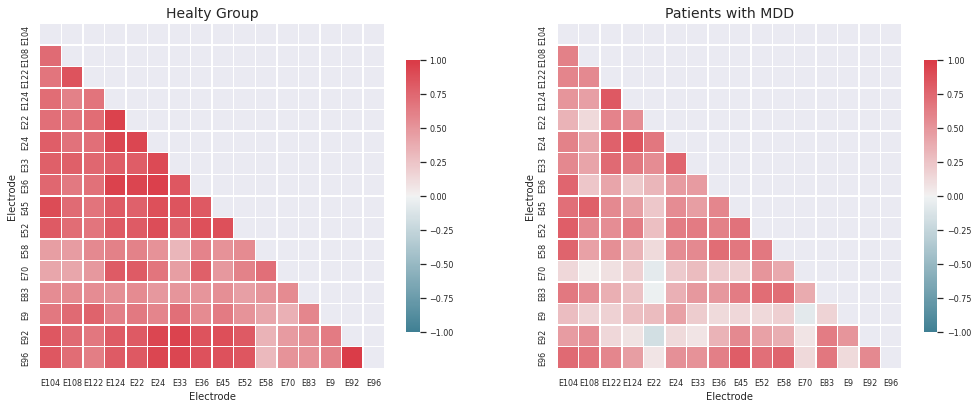

In [ ]:
# For resting phase
plot_sensors_correlation(df_fin, threshold_value=.97)

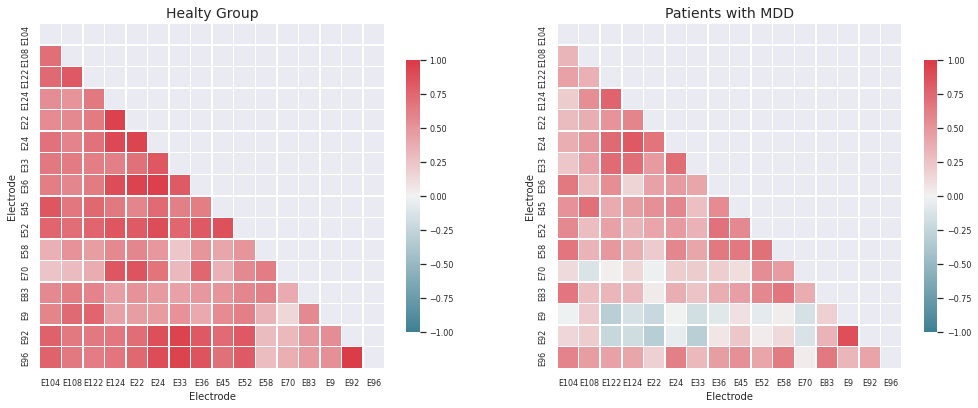

In [ ]:
# For fear stimuli
plot_sensors_correlation(df_fin_fear, threshold_value=.97)

The above chart shows the correlation between the electrodes in the resting phase. While most of the electodes are positively correlated with each other, we see that E22 (Forehead (above left eye) position)emits almost zero to negative correlation amongst patient with MDD. We then took forward the similar analyses to see how it looked for patients when they were shown fear stimuli. Interestingly in fear stimuli we see a patch of negatively correlated electrodes for patients with MDD. These were mostly from electrodes E9 (Forehead (above Right eye) position)and E92 (Back-Above position). The reason behind this could become a part of our future studies.

Check point - Save the file

In [ ]:
final_patient_df.to_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/ERP_Summary_limited.csv',index = False)
final_patient_resting.to_csv('/content/drive/Shareddrives/Panini-Anup-Aparna Capstone Drive/Primary Datasets/EEG data/56 patient dataset/Resting_Summary_limited.csv',index = False)

# Conclusion (Part1)

In this notebook, we learned how to visualize the EEG waveform, implement filters and construct a combined dataframe for further exploration. We will not further explore the attributes that differentiate a MDD patient with normal cases in 